<a href="https://colab.research.google.com/github/spch88/my_project/blob/main/%D0%9F%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D0%B5_%D1%82%D1%80%D0%B0%D1%84%D0%B8%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Используйте базу трафика с сайта компании. 

Напишите модель для прогнозирования трафика. 

При параметре `length = 60`, добейтесь максимально точного соответствия между графиками корреляции исходного сигнала и прогноза.

In [ ]:
import gdown
import pandas as pd
import numpy as np
# Отрисовка графиков
import matplotlib.pyplot as plt
# Нормировщики
from sklearn.preprocessing import MinMaxScaler
# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Sequential
# Основные слои
from tensorflow.keras.layers import Dense, Flatten, Conv1D
# Оптимизаторы
from tensorflow.keras.optimizers import Adam

In [ ]:
#Загружаем базу трафика с сайта компании
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/traff.csv', None, quiet=True)

'traff.csv'

Решение:

In [ ]:
# Назначение размера и стиля графиков по умолчанию
from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

In [ ]:
df = pd.read_csv('traff.csv', header=None, names=['date', 'traf'], thousands=',', index_col='date', parse_dates=['date'])

In [ ]:
print(df.shape)
df.head(10)

(1095, 1)


,traf
date,
2017-01-01,22226.0
2017-01-02,29593.0
2017-01-03,31726.0
2017-01-04,32684.0
2017-01-05,31820.0
2017-01-06,29354.0
2017-01-07,29139.0
2017-01-08,31244.0
2017-01-09,32690.0


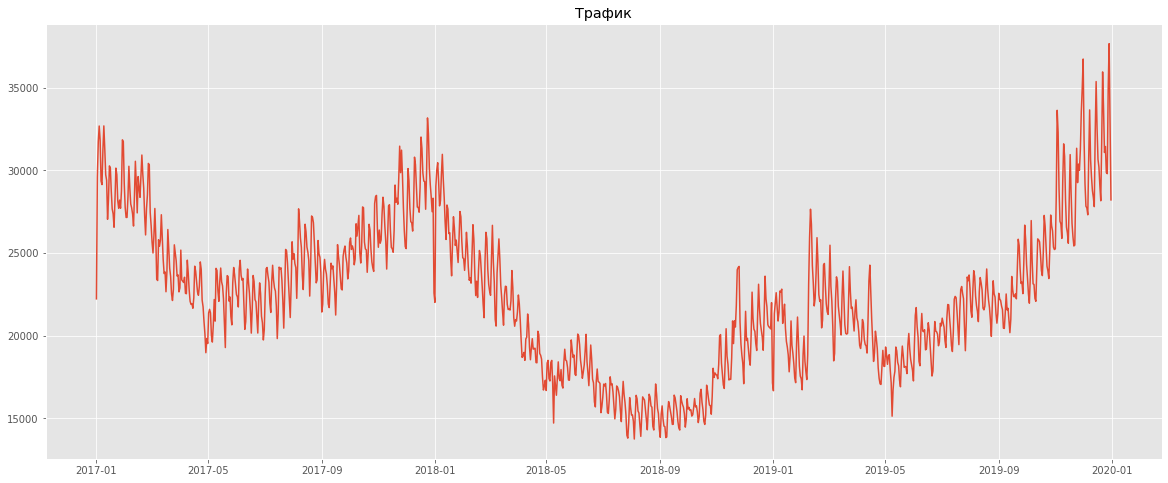

In [ ]:
# Отображение временного ряда в графическом виде
plt.figure(figsize=(20, 8))
plt.plot(df.traf)
plt.title('Трафик')
plt.show()

In [ ]:
# Зададим гиперпараметры
CHANNEL_Y = ['traf']                     # Прогнозные значения
SEQ_LEN = 60                             # История входных данных для анализа
PREDICT_LAG = 1                          # Количество шагов в будущее для предсказания
TEST_LEN = 220                           # Объем тестовой выборки
TRAIN_LEN = df.shape[0] - TEST_LEN       # Объем обучающей выборки
BATCH_SIZE = 20                          # Размер батча

In [ ]:
# Переведем данные в numpy
data = np.array(df) 

# Разделение данных на тренировочный и тестовый наборы
x_data_train, x_data_test = data[:TRAIN_LEN], data[TRAIN_LEN + int(1.2*SEQ_LEN):]
y_data_train, y_data_test = data[:TRAIN_LEN], data[TRAIN_LEN + int(1.2*SEQ_LEN):]

# Масштабирование данных
scaler = MinMaxScaler()
scaler.fit(x_data_train)
x_data_train = scaler.transform(x_data_train)
x_data_test = scaler.transform(x_data_test)

y_data_train = scaler.transform(y_data_train)
y_data_test = scaler.transform(y_data_test)

# Проверка формы данных
print(f'Train data: {x_data_train.shape}, {y_data_train.shape}')
print(f'Test  data: {x_data_test.shape}, {y_data_test.shape}')

Train data: (875, 1), (875, 1)
Test  data: (148, 1), (148, 1)


In [ ]:
# Сервисные функции

# Функция расчета результата прогнозирования сети (предсказания)
def get_pred(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler): # масштабирующий объект для y

    # Вычисление и деномализация предсказания
    y_pred_unscaled = y_scaler.inverse_transform(model.predict(x_test))

    # Денормализация верных ответов
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    # Возврат результата предсказания и верные ответы в исходном масштабе
    return y_pred_unscaled, y_test_unscaled


# Функция расчета корреляционного коэффициента Пирсона для двух рядов
def correlate(a, b):
    return np.corrcoef(a, b)[0, 1]


# Функция визуализации результата предсказания сети и верных ответов
def show_predict(y_pred, y_true, # прогноз данных и исходный ряд
                 start, # точка ряда, с которой начинается отрисовка графика
                 length, # количество точек для отрисовки графика
                 chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
                 chn_names=CHANNEL_Y, # список имен каналов данных
                 title=''):
  
    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    # Построение графика по всем каналам данных
    plt.figure(figsize=(22, 6))
    
    for chn in chn_list:
        plt.plot(y_pred[start:start + length, chn],
                label=f'{chn_names[chn]} Прогноз')
        plt.plot(y_true[start:start + length, chn], 
                label=f'{chn_names[chn]} Базовый')

    plt.title(title)
    plt.xlabel('Время')
    plt.ylabel('Данные')
    plt.legend()
    plt.show()


# Функция отображения корреляций прогнозного ряда и исходного со смещением
def show_corr(y_pred, y_true, # прогноз данных и исходный ряд
              back_steps_max=30, # максимальное количество шагов смещения назад по времени
              chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
              chn_names=CHANNEL_Y, 
              title=''): # список имен каналов данных
  
    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    y_len = y_true.shape[0]
    steps = range(0, back_steps_max + 1)

    # Построение графика по всем каналам данных
    plt.figure(figsize=(14, 7))

    for chn in chn_list:
        # Вычисление коэффициентов корреляции базового ряда и предсказания с разным смещением
        cross_corr = [correlate(y_true[:y_len - step, chn], y_pred[step:, chn]) for step in steps]
        # Вычисление коэффициентов автокорреляции базового ряда с разным смещением
        auto_corr = [correlate(y_true[:y_len - step, chn], y_true[step:, chn]) for step in steps]

        plt.plot(cross_corr, label=f'{chn_names[chn]} Прогноз')
        plt.plot(auto_corr, label=f'{chn_names[chn]} Эталон')

    plt.title(title)
    
    # Назначение меток шкалы оси x
    plt.xticks(steps)
    plt.xlabel('Шаги смещения')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.show()


# Функция визуализации результата работы сети
def eval_net(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler, # нормировщик выхода
             start=0, length=500, back_steps_max=30, # параметры отображения графиков
             title=''):
  
    # Получение денормализованного предсказания и данных базового ряда
    y_pred, y_true = get_pred(model, x_test, y_test, y_scaler)
    
    # Отрисовка графика сопоставления базового и прогнозного рядов
    # Прогнозный ряд сдвигается на 1 шаг назад, так как предсказание делалось на 1 шаг вперед 
    show_predict(y_pred[1:], y_true[:-1], start, length, 
                 title=f'{title}: Сопоставление базового и прогнозного рядов')
    # Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
    show_corr(y_pred, y_true, back_steps_max=back_steps_max, 
              title=f'{title}: Корреляционные коэффициенты по шагам смещения') 


# Функция обучения модели и отрисовки прогресса и оценки результатов 
def train_eval_net(model, # модель
                   train_datagen, val_datagen, 
                   epoch_list, 
                   x_test, y_test, 
                   y_scaler, 
                   start=0, 
                   length=500, 
                   back_steps_max=30, 
                   title=''):
  
    # Отображение сводки модели
    model.summary()

    # Обучение модели в несколько фаз в соответствии со списком epoch_list
    for epochs, opt in epoch_list:
        # Компиляция модели
        model.compile(loss='mse', optimizer=opt)
        # Фаза обучения модели
        print(f'Обучение {epochs} эпох')
        history = model.fit(train_datagen, 
                            epochs=epochs, 
                            validation_data=val_datagen,
                            verbose=1)

        # Рисование графиков прошедшей фазы обучения
        fig = plt.figure(figsize=(14, 7))
        plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
        plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
        plt.title(f'{title}: График прогресса обучения')
        # Указание показывать только целые метки шкалы оси x
        fig.gca().xaxis.get_major_locator().set_params(integer=True)
        plt.xlabel('Эпоха обучения')
        plt.ylabel('Средняя ошибка')
        plt.legend()
        plt.show()

        # Рисование графиков оценки результата работы модели после фазы обучения
        eval_net(model, x_test, y_test, y_scaler, start=start, 
                 length=length, back_steps_max=back_steps_max, title=title)           

In [ ]:
# Создание генератора для обучения
train_datagen = TimeseriesGenerator(x_data_train, 
                                    y_data_train,
                                    length=SEQ_LEN,
                                    stride=1,
                                    sampling_rate=1,
                                    batch_size=BATCH_SIZE)

# Генератор для валидации при обучении
val_datagen = TimeseriesGenerator(x_data_test, 
                                  y_data_test,
                                  length=SEQ_LEN,
                                  stride=1,
                                  sampling_rate=1,
                                  batch_size=BATCH_SIZE)

# Генератор тестовой выборки, генерирует один батч на всю выборку
test_datagen = TimeseriesGenerator(x_data_test, 
                                   y_data_test,
                                   length=SEQ_LEN,
                                   stride=1,
                                   sampling_rate=1,
                                   batch_size=x_data_test.shape[0])

# Формирование тестовой выборки из генератора
x_test, y_test = test_datagen[0]

# Проверка формы выдаваемого генератором результата
print(f'Train batch x: {train_datagen[0][0].shape}, y: {train_datagen[0][1].shape}')
# Проверка формы тестовой выборки
print(f'Test x: {x_test.shape}, y: {y_test.shape}')

Train batch x: (20, 60, 1), y: (20, 1)
Test x: (88, 60, 1), y: (88, 1)


Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_33 (Conv1D)          (None, 56, 300)           1800      
                                                                 
 flatten_34 (Flatten)        (None, 16800)             0         
                                                                 
 dense_82 (Dense)            (None, 50)                840050    
                                                                 
 dense_83 (Dense)            (None, 10)                510       
                                                                 
 dense_84 (Dense)            (None, 1)                 11        
                                                                 
Total params: 842,371
Trainable params: 842,371
Non-trainable params: 0
_________________________________________________________________
Обучение 30 эпох
Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


41/41 [==============================] - 1s 10ms/step - loss: 0.0322 - val_loss: 0.0118
Epoch 2/30
41/41 [==============================] - 0s 6ms/step - loss: 0.0511 - val_loss: 0.1403
Epoch 3/30
41/41 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 0.0078
Epoch 4/30
41/41 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0144
Epoch 5/30
41/41 [==============================] - 0s 6ms/step - loss: 0.0070 - val_loss: 0.0080
Epoch 6/30
41/41 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0088
Epoch 7/30
41/41 [==============================] - 0s 6ms/step - loss: 0.0072 - val_loss: 0.0114
Epoch 8/30
41/41 [==============================] - 0s 6ms/step - loss: 0.0078 - val_loss: 0.0196
Epoch 9/30
41/41 [==============================] - 0s 6ms/step - loss: 0.0044 - val_loss: 0.0145
Epoch 10/30
41/41 [==============================] - 0s 6ms/step - loss: 0.0050 - val_loss: 0.0150
Epoch 11/30
41/41 [==========

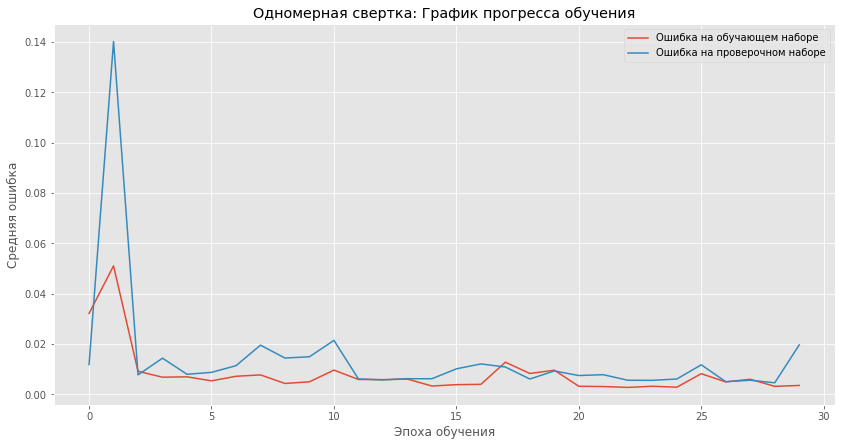

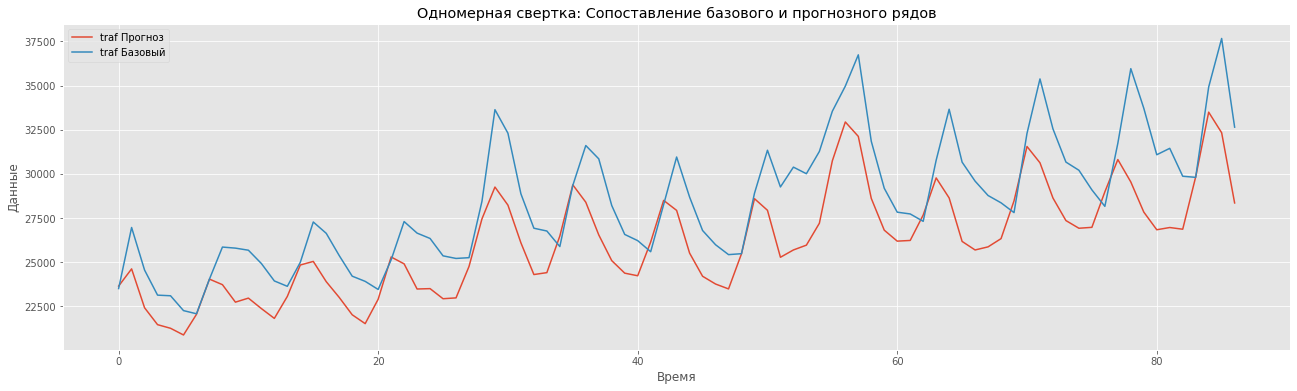

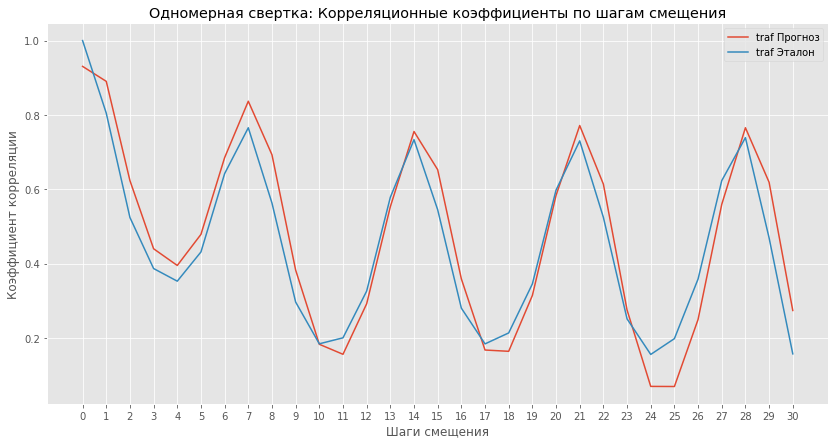

Обучение 30 эпох
Epoch 1/30
41/41 [==============================] - 1s 9ms/step - loss: 0.0034 - val_loss: 0.0047
Epoch 2/30
41/41 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0046
Epoch 3/30
41/41 [==============================] - 0s 6ms/step - loss: 0.0025 - val_loss: 0.0061
Epoch 4/30
41/41 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0045
Epoch 5/30
41/41 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0044
Epoch 6/30
41/41 [==============================] - 0s 6ms/step - loss: 0.0025 - val_loss: 0.0044
Epoch 7/30
41/41 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0055
Epoch 8/30
41/41 [==============================] - 0s 6ms/step - loss: 0.0025 - val_loss: 0.0045
Epoch 9/30
41/41 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0046
Epoch 10/30
41/41 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0046
Ep

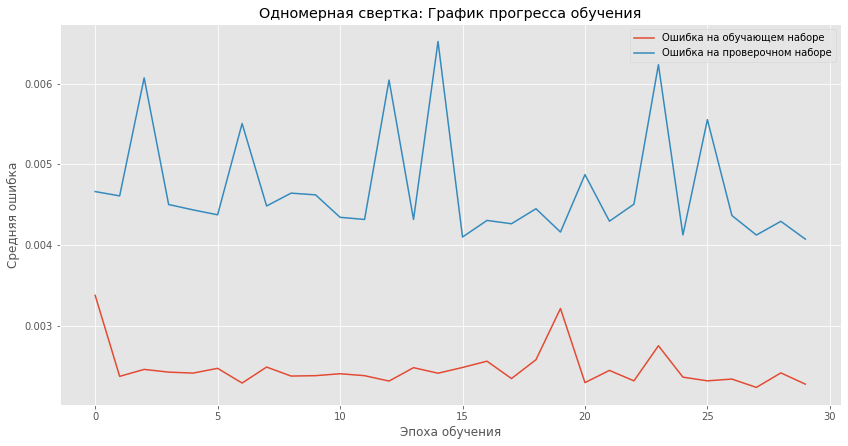

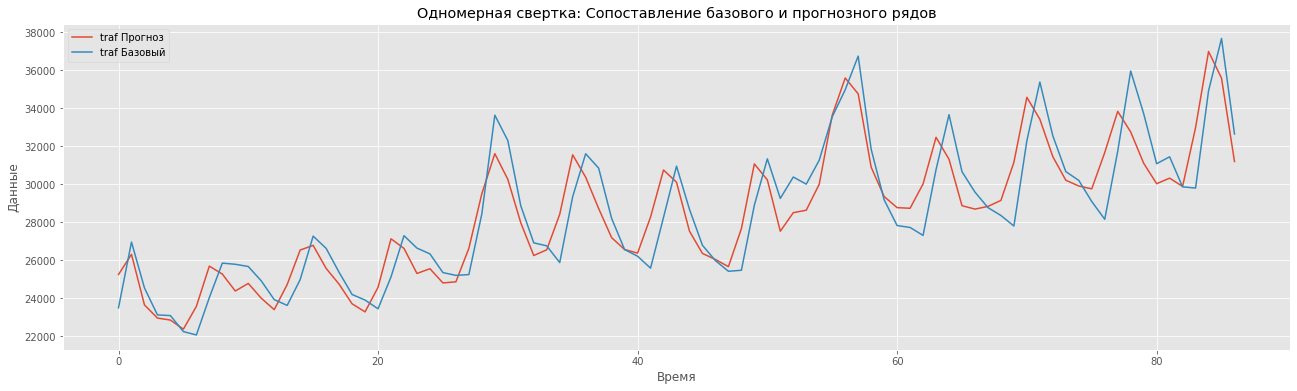

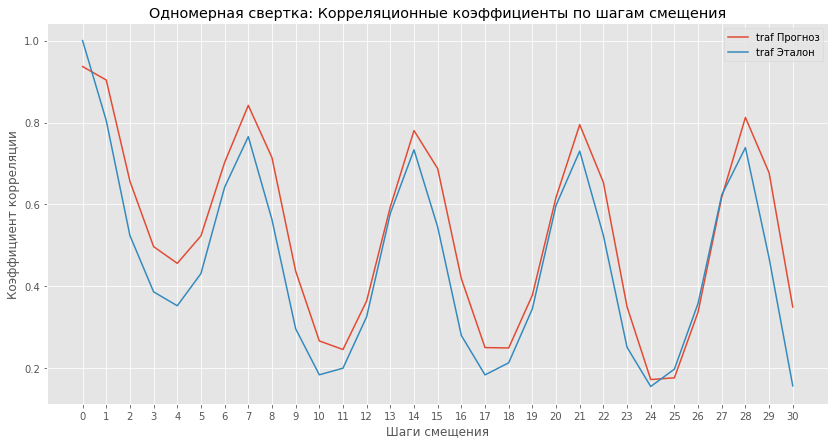

Обучение 30 эпох
Epoch 1/30
41/41 [==============================] - 1s 10ms/step - loss: 0.0023 - val_loss: 0.0044
Epoch 2/30
41/41 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0046
Epoch 3/30
41/41 [==============================] - 0s 7ms/step - loss: 0.0022 - val_loss: 0.0044
Epoch 4/30
41/41 [==============================] - 0s 7ms/step - loss: 0.0023 - val_loss: 0.0042
Epoch 5/30
41/41 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0040
Epoch 6/30
41/41 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0041
Epoch 7/30
41/41 [==============================] - 0s 7ms/step - loss: 0.0022 - val_loss: 0.0044
Epoch 8/30
41/41 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0042
Epoch 9/30
41/41 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0041
Epoch 10/30
41/41 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0061
E

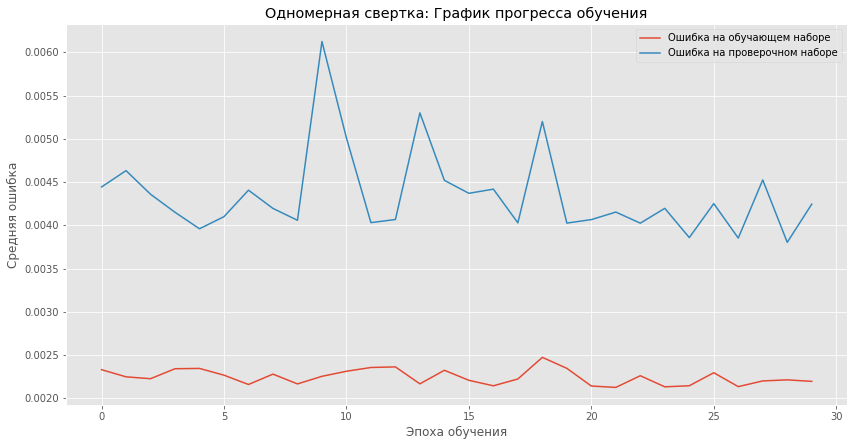

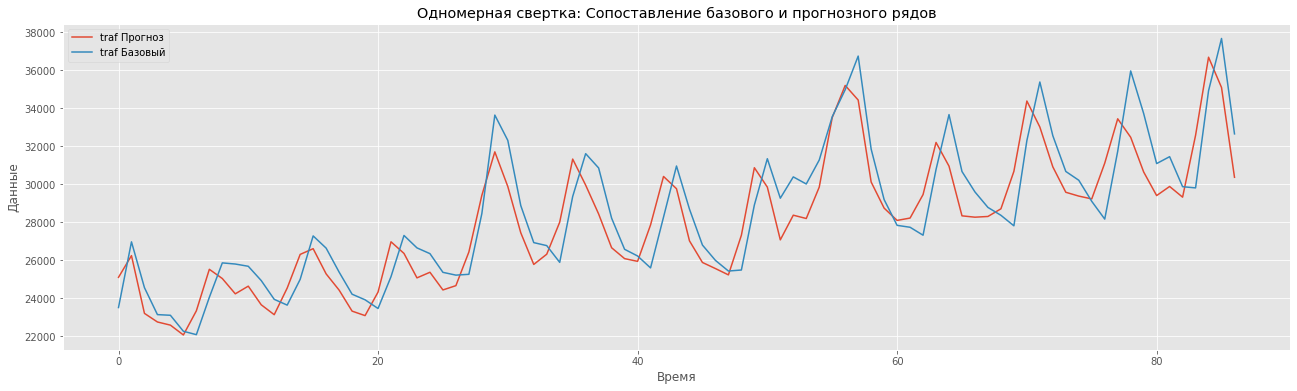

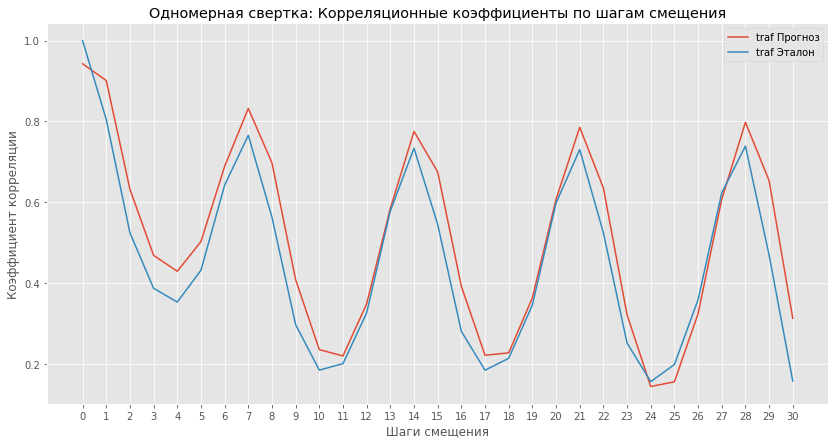

In [ ]:
# Создадим модель с одномерной сверткой
model = Sequential()
model.add(Conv1D(300, 5, input_shape=x_test.shape[1:], activation='linear'))

model.add(Flatten())
model.add(Dense(50, activation='linear'))
model.add(Dense(10, activation='linear'))
model.add(Dense(y_test.shape[1], activation='linear'))

# Обучение модели 3x30 эпох
train_eval_net(model, train_datagen, val_datagen, [(30, Adam(lr=1e-4)),
                                                   (30, Adam(lr=1e-5)),
                                                   (30, Adam(lr=1e-5))],
               x_test, y_test, scaler, title='Одномерная свертка')